In [1]:
import os
import shutil
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random
from tensorflow.keras import backend as K

# Dataset loading and preprocessing

In [2]:
def get_positional_encodings(sequence_length, d_model):
    PE = np.zeros((sequence_length, d_model))
    positions = np.arange(sequence_length)[:, np.newaxis]
    dimension_indices = np.arange(d_model)[np.newaxis, :]
    div_term = 10000 ** (2 * (dimension_indices // 2) / d_model)
    PE[:, 0::2] = np.sin(positions / div_term[:, 0::2])
    PE[:, 1::2] = np.cos(positions / div_term[:, 1::2])
    return PE

lst = []
sc = MinMaxScaler(feature_range=(0, 1))
directory = '/kaggle/input/soh-data-mit/data'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df = pd.read_csv(f)
    C = max(df['capacity'])
    SoH = np.array(df['capacity'] / C)
    df_transformed = pd.DataFrame(sc.fit_transform(df), columns=df.columns)
    df_transformed['SoH'] = SoH
    df_transformed = df_transformed.drop(columns = ['capacity','current slope','current std','current entropy'])
#     PE = get_positional_encodings(len(df), 16)
#     for i in range(16):
#         df_transformed[f'PE_{i}'] = PE[:, i]
    lst.append(df_transformed)

data = []

threshold = 0.03

index = [19,52,56,63,89]

for i in range(len(lst)):
    if i in index:
        continue
    df = pd.DataFrame(lst[i])
    y = np.array(df['SoH'])
    x = np.arange(len(df)).reshape(-1, 1)
    degree = 4 
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x)
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    df['SoH_pred'] = y_pred
    indices = []
    for _ in range(len(df)):
        if abs(y_pred[_]-y[_])<threshold:
            indices.append(True)
        else:
            indices.append(False)
    df = df[indices]
    data.append(df)

In [3]:
data[0].columns

Index(['voltage mean', 'voltage std', 'voltage kurtosis', 'voltage skewness',
       'CC Q', 'CC charge time', 'voltage slope', 'voltage entropy',
       'current mean', 'current kurtosis', 'current skewness', 'CV Q',
       'CV charge time', 'SoH', 'SoH_pred'],
      dtype='object')

# EDA

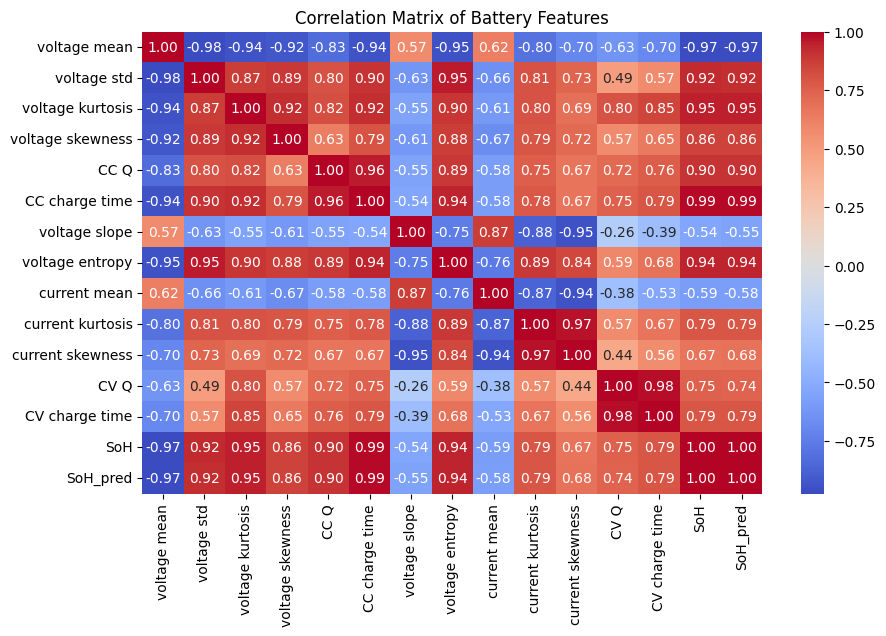

In [4]:
# Correlation matrix
df = pd.DataFrame(data[0])
# df = df.drop(columns = [ 'PE_0', 'PE_1', 'PE_2', 'PE_3', 'PE_4', 'PE_5',
#        'PE_6', 'PE_7', 'PE_8', 'PE_9', 'PE_10', 'PE_11', 'PE_12', 'PE_13',
#        'PE_14', 'PE_15'])
correlation_matrix = df.corr()
compilation_matrix = np.copy(correlation_matrix)
for i in range(len(data)-1):
    df = pd.DataFrame(data[0])
#     df = df.drop(columns = [ 'PE_0', 'PE_1', 'PE_2', 'PE_3', 'PE_4', 'PE_5',
#        'PE_6', 'PE_7', 'PE_8', 'PE_9', 'PE_10', 'PE_11', 'PE_12', 'PE_13',
#        'PE_14', 'PE_15'])
    correlation_matrix = df.corr()
    compilation_matrix+=correlation_matrix
compilation_matrix/=len(data)
plt.figure(figsize=(10, 6))
sns.heatmap(compilation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Battery Features')
plt.show()

In [5]:
data[0].columns

Index(['voltage mean', 'voltage std', 'voltage kurtosis', 'voltage skewness',
       'CC Q', 'CC charge time', 'voltage slope', 'voltage entropy',
       'current mean', 'current kurtosis', 'current skewness', 'CV Q',
       'CV charge time', 'SoH', 'SoH_pred'],
      dtype='object')

In [6]:
def create_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=256, activation='tanh', input_shape=input_shape))
    model.add(tf.keras.layers.Dense(units=128, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=32, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=1, activation='tanh'))
    return model

In [7]:
margin = 0.005
def custom_loss(y_true_soh_pred, y_pred):
    y_true = y_true_soh_pred[:, 0:1]  
    soh_pred = y_true_soh_pred[:, 1:2]
    y_prev = y_true_soh_pred[:,2:3]
    data_loss = K.mean(K.square(y_true - y_pred))
    smooth_loss = K.mean(K.square(soh_pred - y_pred))
    physics_loss = K.mean(tf.nn.relu(y_prev - y_pred+margin))
    total_loss = data_loss + smooth_loss+0.01*physics_loss
    return total_loss

In [8]:
PINN = create_model((data[0].shape[1]-2,))
PINN.compile(optimizer=Adam(learning_rate = 1e-4), loss=custom_loss,metrics = ['mse'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
PINN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# import random
# random.shuffle(data)
train  = data[5:]
test = data[:5]

In [11]:
loss = []
epochs = 20
y_last = []
for i in range(len(train)):
    df = pd.DataFrame(train[i])
    y_last.append(df['SoH'])
for epoch in range(epochs):
    epoch_loss = 0  
    batches = 0 
    indices = np.random.permutation(len(train))
    train = [train[i] for i in indices]  
    y_last = [y_last[i] for i in indices] 
    for i in range(len(train)):
        df = pd.DataFrame(train[i])
        indices = np.random.permutation(len(df))
        y = np.array(df['SoH']).reshape(-1, 1)
        y_prev  = np.copy(y_last[i]).reshape(-1,1)
        pred = np.array(df['SoH_pred']).reshape(-1, 1)
        df = df.drop(columns=['SoH','SoH_pred'])
        y_combined = np.concatenate([y, pred,y_prev], axis=1)
        X = np.array(df)
        history = PINN.fit(X, y_combined, epochs=1, batch_size=8, verbose=0,shuffle=False)
        batch_loss = history.history['loss'][0]  
        epoch_loss += batch_loss 
        batches += 1
        y_prev = PINN.predict(X,verbose=0)
        temp = np.copy([x[0] for x in y_prev])
        y_prev = [1]
        y_prev.extend(temp[:-1])
        y_last[i] = y_prev
    avg_epoch_loss = epoch_loss
    loss.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss[epoch]:.4f}')

Epoch 1/20, Loss: 0.2119
Epoch 2/20, Loss: 0.1780
Epoch 3/20, Loss: 0.0478
Epoch 4/20, Loss: 0.0576
Epoch 5/20, Loss: 0.0669
Epoch 6/20, Loss: 0.0591
Epoch 7/20, Loss: 0.0993
Epoch 8/20, Loss: 0.0389
Epoch 9/20, Loss: 0.0305
Epoch 10/20, Loss: 0.0795
Epoch 11/20, Loss: 0.0456
Epoch 12/20, Loss: 0.0401
Epoch 13/20, Loss: 0.0409
Epoch 14/20, Loss: 0.0315
Epoch 15/20, Loss: 0.0351
Epoch 16/20, Loss: 0.0369
Epoch 17/20, Loss: 0.0309
Epoch 18/20, Loss: 0.0409
Epoch 19/20, Loss: 0.0266
Epoch 20/20, Loss: 0.0298


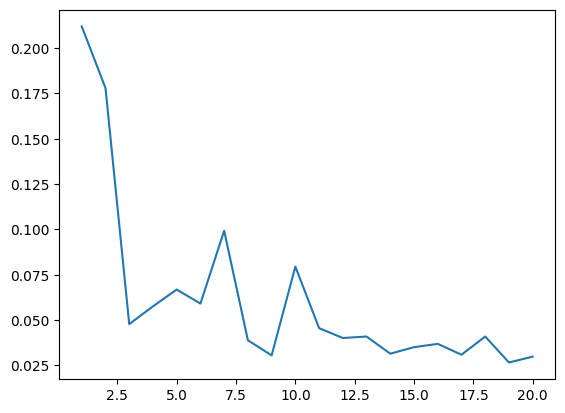

In [12]:
x_ax = np.arange(epochs)+1
plt.plot(x_ax,loss)
plt.show()

(92, 13)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


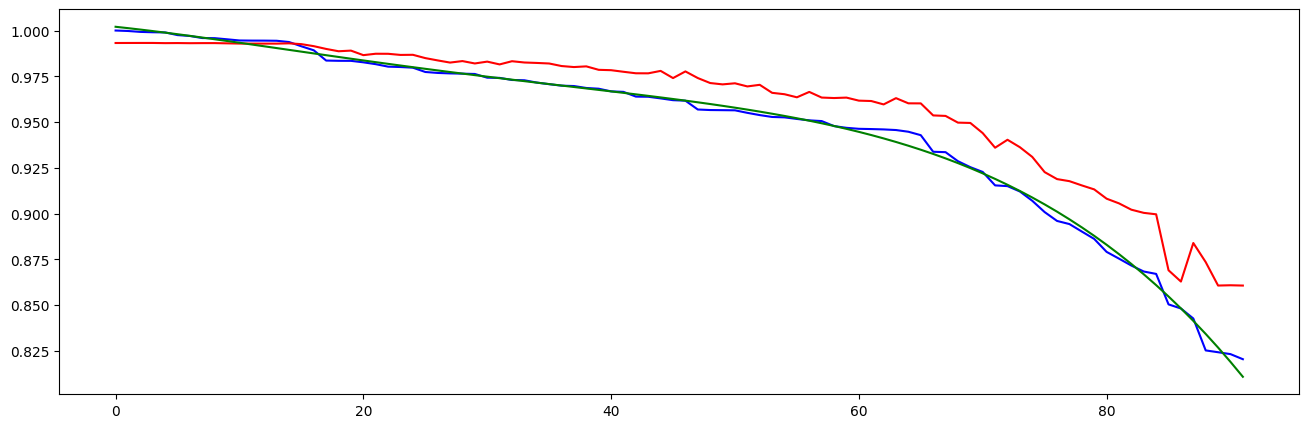

(732, 13)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


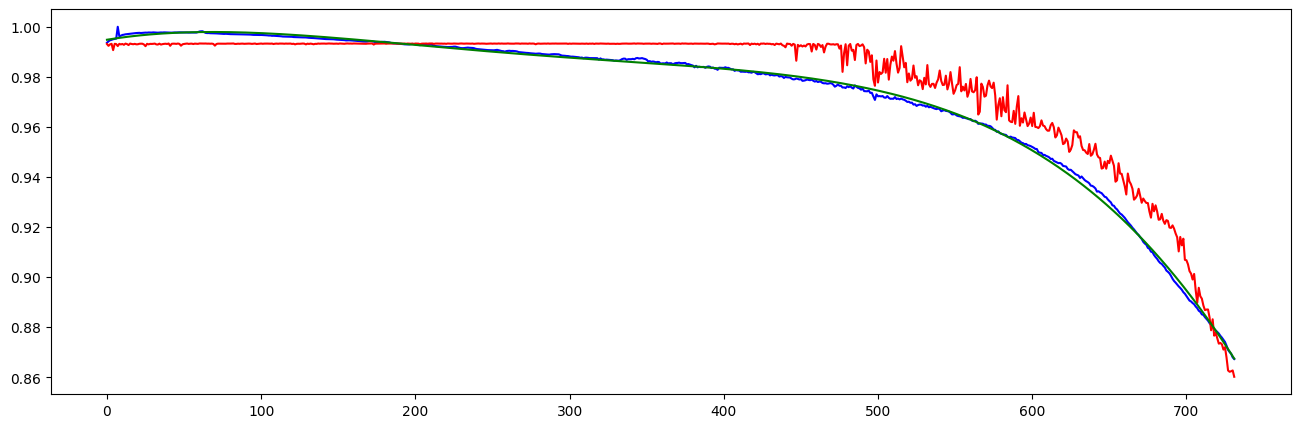

(590, 13)
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


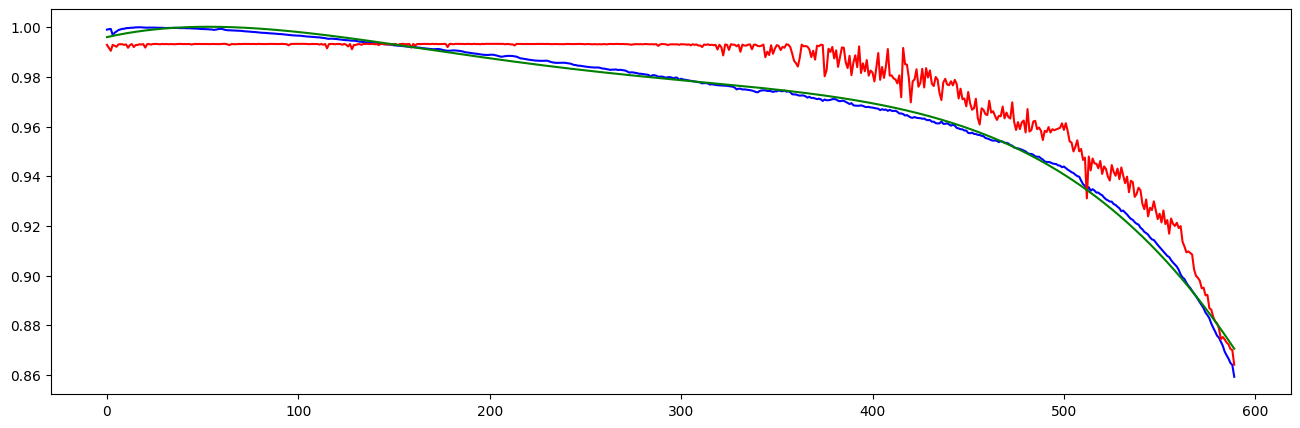

(420, 13)
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


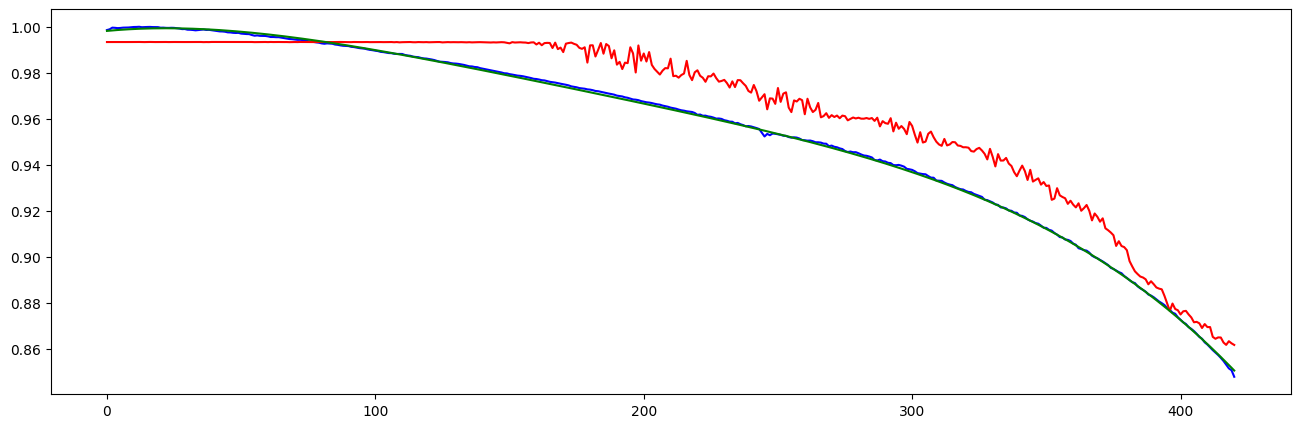

(736, 13)
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


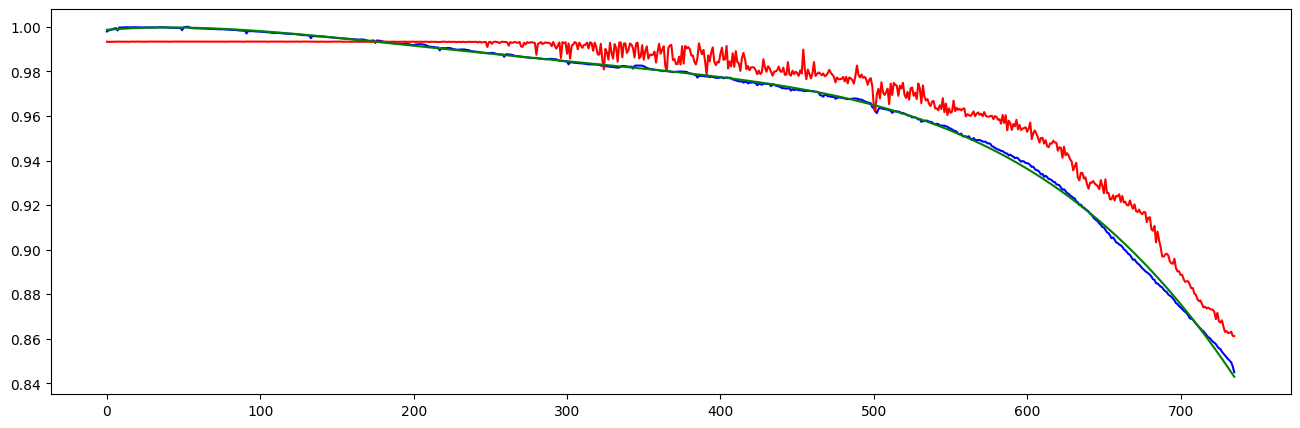

In [13]:
for i in range(len(test)):
    df = pd.DataFrame(test[i])
    y = np.array(df['SoH'])
    z = np.array(df['SoH_pred'])
    df = df.drop(columns  = ['SoH','SoH_pred'])
    X  = np.array(df)
    print(X.shape)
    pred = PINN.predict(X)
    plt.figure(figsize=(16, 5))
    plt.plot(df.index, y, label="Actual data", color='blue')
    plt.plot(df.index, pred,label="Prediction data", color='red')
    plt.plot(df.index, z,label="Prediction data", color='green')
    plt.show()

In [14]:
train[0].head()

,voltage mean,voltage std,voltage kurtosis,voltage skewness,CC Q,CC charge time,voltage slope,voltage entropy,current mean,current kurtosis,current skewness,CV Q,CV charge time,SoH,SoH_pred
0,0.080742,0.171135,0.644144,0.815333,0.930247,0.930244,0.441469,0.917133,0.238266,0.737652,0.794883,0.512602,0.702654,0.996376,0.995329
1,0.085116,0.185849,0.616354,0.811701,0.941884,0.941863,0.466932,0.954469,0.328971,0.545284,0.647984,0.424934,0.567540,0.997022,0.995563
2,0.048226,0.240855,0.695311,0.890440,0.941900,0.941867,0.439049,0.939047,0.188153,0.708495,0.817337,0.400923,0.594583,0.997762,0.995792
3,0.066535,0.223408,0.711435,0.888214,0.953480,0.953478,0.454690,0.938915,0.130690,0.735482,0.814432,0.368325,0.486430,0.997832,0.996014
4,0.057859,0.244514,0.690402,0.892089,0.941856,0.941860,0.473270,0.930156,0.223159,0.554825,0.660391,0.409833,0.567522,0.998041,0.996231
